# Dataset experimentation and Training

In [1]:
# IMPORTS-------------------------
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.naive_bayes import BernoulliNB, CategoricalNB
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFECV, RFE

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, balanced_accuracy_score

from scipy.stats import ttest_1samp
#-------------

CONFIG__DATA_FILE_NAME = 'plunder-RAD2MODE70-from2022-09-23-to2022-10-24'
#CONFIG__DATA_FILE_NAME = 'seraph-RAD2MODE70-from2022-12-09-to2023-02-20'
#CONFIG__DATA_FILE_NAME = 'lightfall-RAD2MODE70-from2023-02-28-to2023-03-22'

release = CONFIG__DATA_FILE_NAME[:CONFIG__DATA_FILE_NAME.find('-')]

In [2]:
df = pd.read_csv('data/csv/'+CONFIG__DATA_FILE_NAME + ".csv")

df.sort_values(by='Global Usage Rate (%)', ascending=False)

,Name,Weapon Type,Archetype,Slot,WeaponID,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,...,Tap the Trigger present in any Column,Meganeura present in any Column,Timed Payload present in any Column,Ambitious Assassin present in any Column,Energy Transfer present in any Column,Slideways present in any Column,Eager Edge present in any Column,Usage Rate in Slot (%),Global Usage Rate (%),Popularity Category
50,Mechabre,Sniper Rifle,Aggressive Frame,Special,1280894514,28,26,74,41,5,...,0,0,0,0,0,0,0,14.057924,4.575060,Popular
30,BxR-55 Battler,Pulse Rifle,Legacy PR-55 Frame,Primary,2708806099,59,71,50,85,10,...,0,0,0,0,0,0,0,6.852627,3.902568,Popular
31,Wastelander M5,Shotgun,Lightweight Frame,Special,1679868061,40,66,44,49,2,...,0,0,0,0,0,0,0,8.672307,2.822346,Popular
46,Austringer,Hand Cannon,Adaptive Frame,Primary,3055790362,59,47,46,75,13,...,0,0,0,0,0,0,0,4.741980,2.700556,Popular
14,Out of Bounds,Submachine Gun,Lightweight Frame,Primary,2988121501,43,67,32,55,23,...,1,0,0,0,0,0,0,4.109716,2.340482,Popular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,Stubborn Oak,Shotgun,Aggressive Frame,Special,1977926913,14,18,17,21,-1,...,0,0,0,0,0,0,0,0.016271,0.005295,Unpopular
409,Talons of the Eagle,Scout Rifle,High-Impact Frame,Primary,1982711279,29,26,68,30,10,...,0,0,0,1,0,0,0,0.009298,0.005295,Unpopular
112,BrayTech Winter Wolf,Auto Rifle,Precision Frame,Primary,1752585070,41,39,69,47,10,...,0,0,0,0,0,0,0,0.009298,0.005295,Unpopular
407,Bane of Sorrow,Machine Gun,High-Impact Frame,Power,1496419775,22,39,68,30,6,...,1,0,0,0,0,0,0,0.050403,0.005295,Unpopular


## Convert numerical popularity data to category-based

[19.58379666 44.39184538 70.00794281 80.24357956 92.52581414]


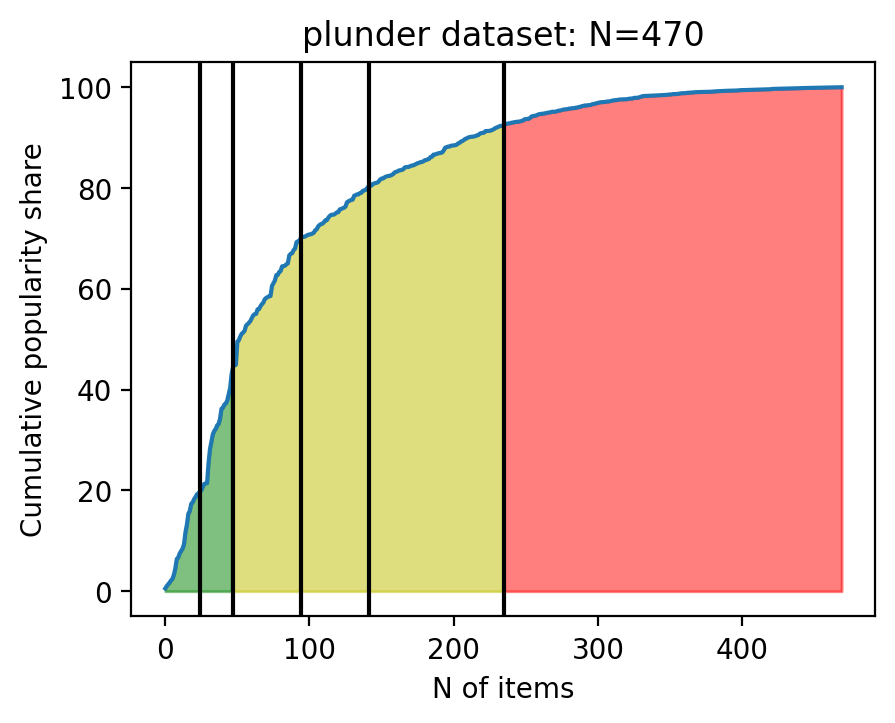

In [3]:
csum = np.cumsum(df["Global Usage Rate (%)"])

def count_n_under(arr, x):
    return (arr < x).sum()

percentiles = np.percentile(csum, [5, 10, 20, 30, 50])
print(percentiles)
plt.plot(csum)
for v in percentiles:
    plt.axvline(x=count_n_under(csum, v))

plt.fill_between(x=np.arange(0, df.shape[0]), y1=csum,
                 where=(csum<percentiles[1]),
                 color='g',
                 alpha=0.5
                )
plt.fill_between(x=np.arange(0, df.shape[0]), y1=csum,
                 where=(csum>percentiles[1])&(csum<percentiles[-1]),
                 color='y',
                 alpha=0.5
                )
plt.fill_between(x=np.arange(0, df.shape[0]), y1=csum,
                 where=(csum>percentiles[-1]),
                 color='r',
                 alpha=0.5
                )

plt.xlabel("N of items")
plt.ylabel("Cumulative popularity share")
plt.title(f'{release} dataset: N={df.shape[0]}')

plt.show()

NOTE: graph and the code below for assigning a label are mirrored. this means that the label 'unpopular', in code assigned to items in the lower 50% of GUR are represented in the graph by the big plateau to the right of the 50th percentile split. Following that same logic, items in the 'popular' category (top 10% of GUR) are represented in the graph by the section left of the 10th percentile

## Prelude: KFold settings, df conversion

In [4]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=67)

feat_to_drop = ["Name", "WeaponID", "Ocurrences", "Global Usage Rate (%)", "Usage Rate in Slot (%)"]
df_2 = df.drop(feat_to_drop, axis=1)

empty_columns = (df_2.sum(axis=0)) == 0
df_2 = df_2.loc[:, ~empty_columns]


lc = LabelEncoder()

feat_to_encode = ["Slot", "Archetype", "Weapon Type"]
for f in feat_to_encode:
    df_2[f] = lc.fit_transform(df_2[f])

conv = []
for i in range(df_2.shape[0]):
    cat = df_2.iloc[i]['Popularity Category']
    if cat == 'Niche':
        conv.append(1)
    elif cat == 'Popular':
        conv.append(2)
    else: # unpopular
        conv.append(0)

df_2['Popularity Category'] = conv

arr = df_2.to_numpy()
X = arr[:, :-1]
Y = arr[:, -1].astype(int)

In [5]:
X.sum(axis=0).shape[0]

166

In [6]:
df_2

,Weapon Type,Archetype,Slot,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,Recoil Direction,Zoom,...,Hip-Fire Grip present in any Column,Under-Over present in any Column,Tap the Trigger present in any Column,Meganeura present in any Column,Timed Payload present in any Column,Ambitious Assassin present in any Column,Energy Transfer present in any Column,Slideways present in any Column,Eager Edge present in any Column,Popularity Category
0,10,11,1,40,39,49,64,17,76,20,...,0,0,0,0,0,0,0,0,0,1
1,13,0,2,46,47,50,68,2,77,45,...,0,0,0,0,0,0,0,0,0,1
2,10,12,1,42,18,24,67,10,54,26,...,1,0,0,0,0,0,0,0,0,1
3,11,3,2,29,31,29,39,4,69,12,...,0,0,0,0,0,0,0,1,0,1
4,8,5,1,54,26,65,32,19,70,18,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,0,11,1,40,36,50,44,10,70,20,...,0,0,0,0,0,0,0,0,0,0
466,8,12,1,49,22,34,82,10,55,17,...,0,0,0,0,0,1,0,0,0,0
467,8,0,1,50,44,49,60,10,73,17,...,0,0,0,0,0,0,0,0,0,0
468,10,8,1,32,63,33,67,10,59,20,...,0,0,0,0,0,0,0,0,0,0


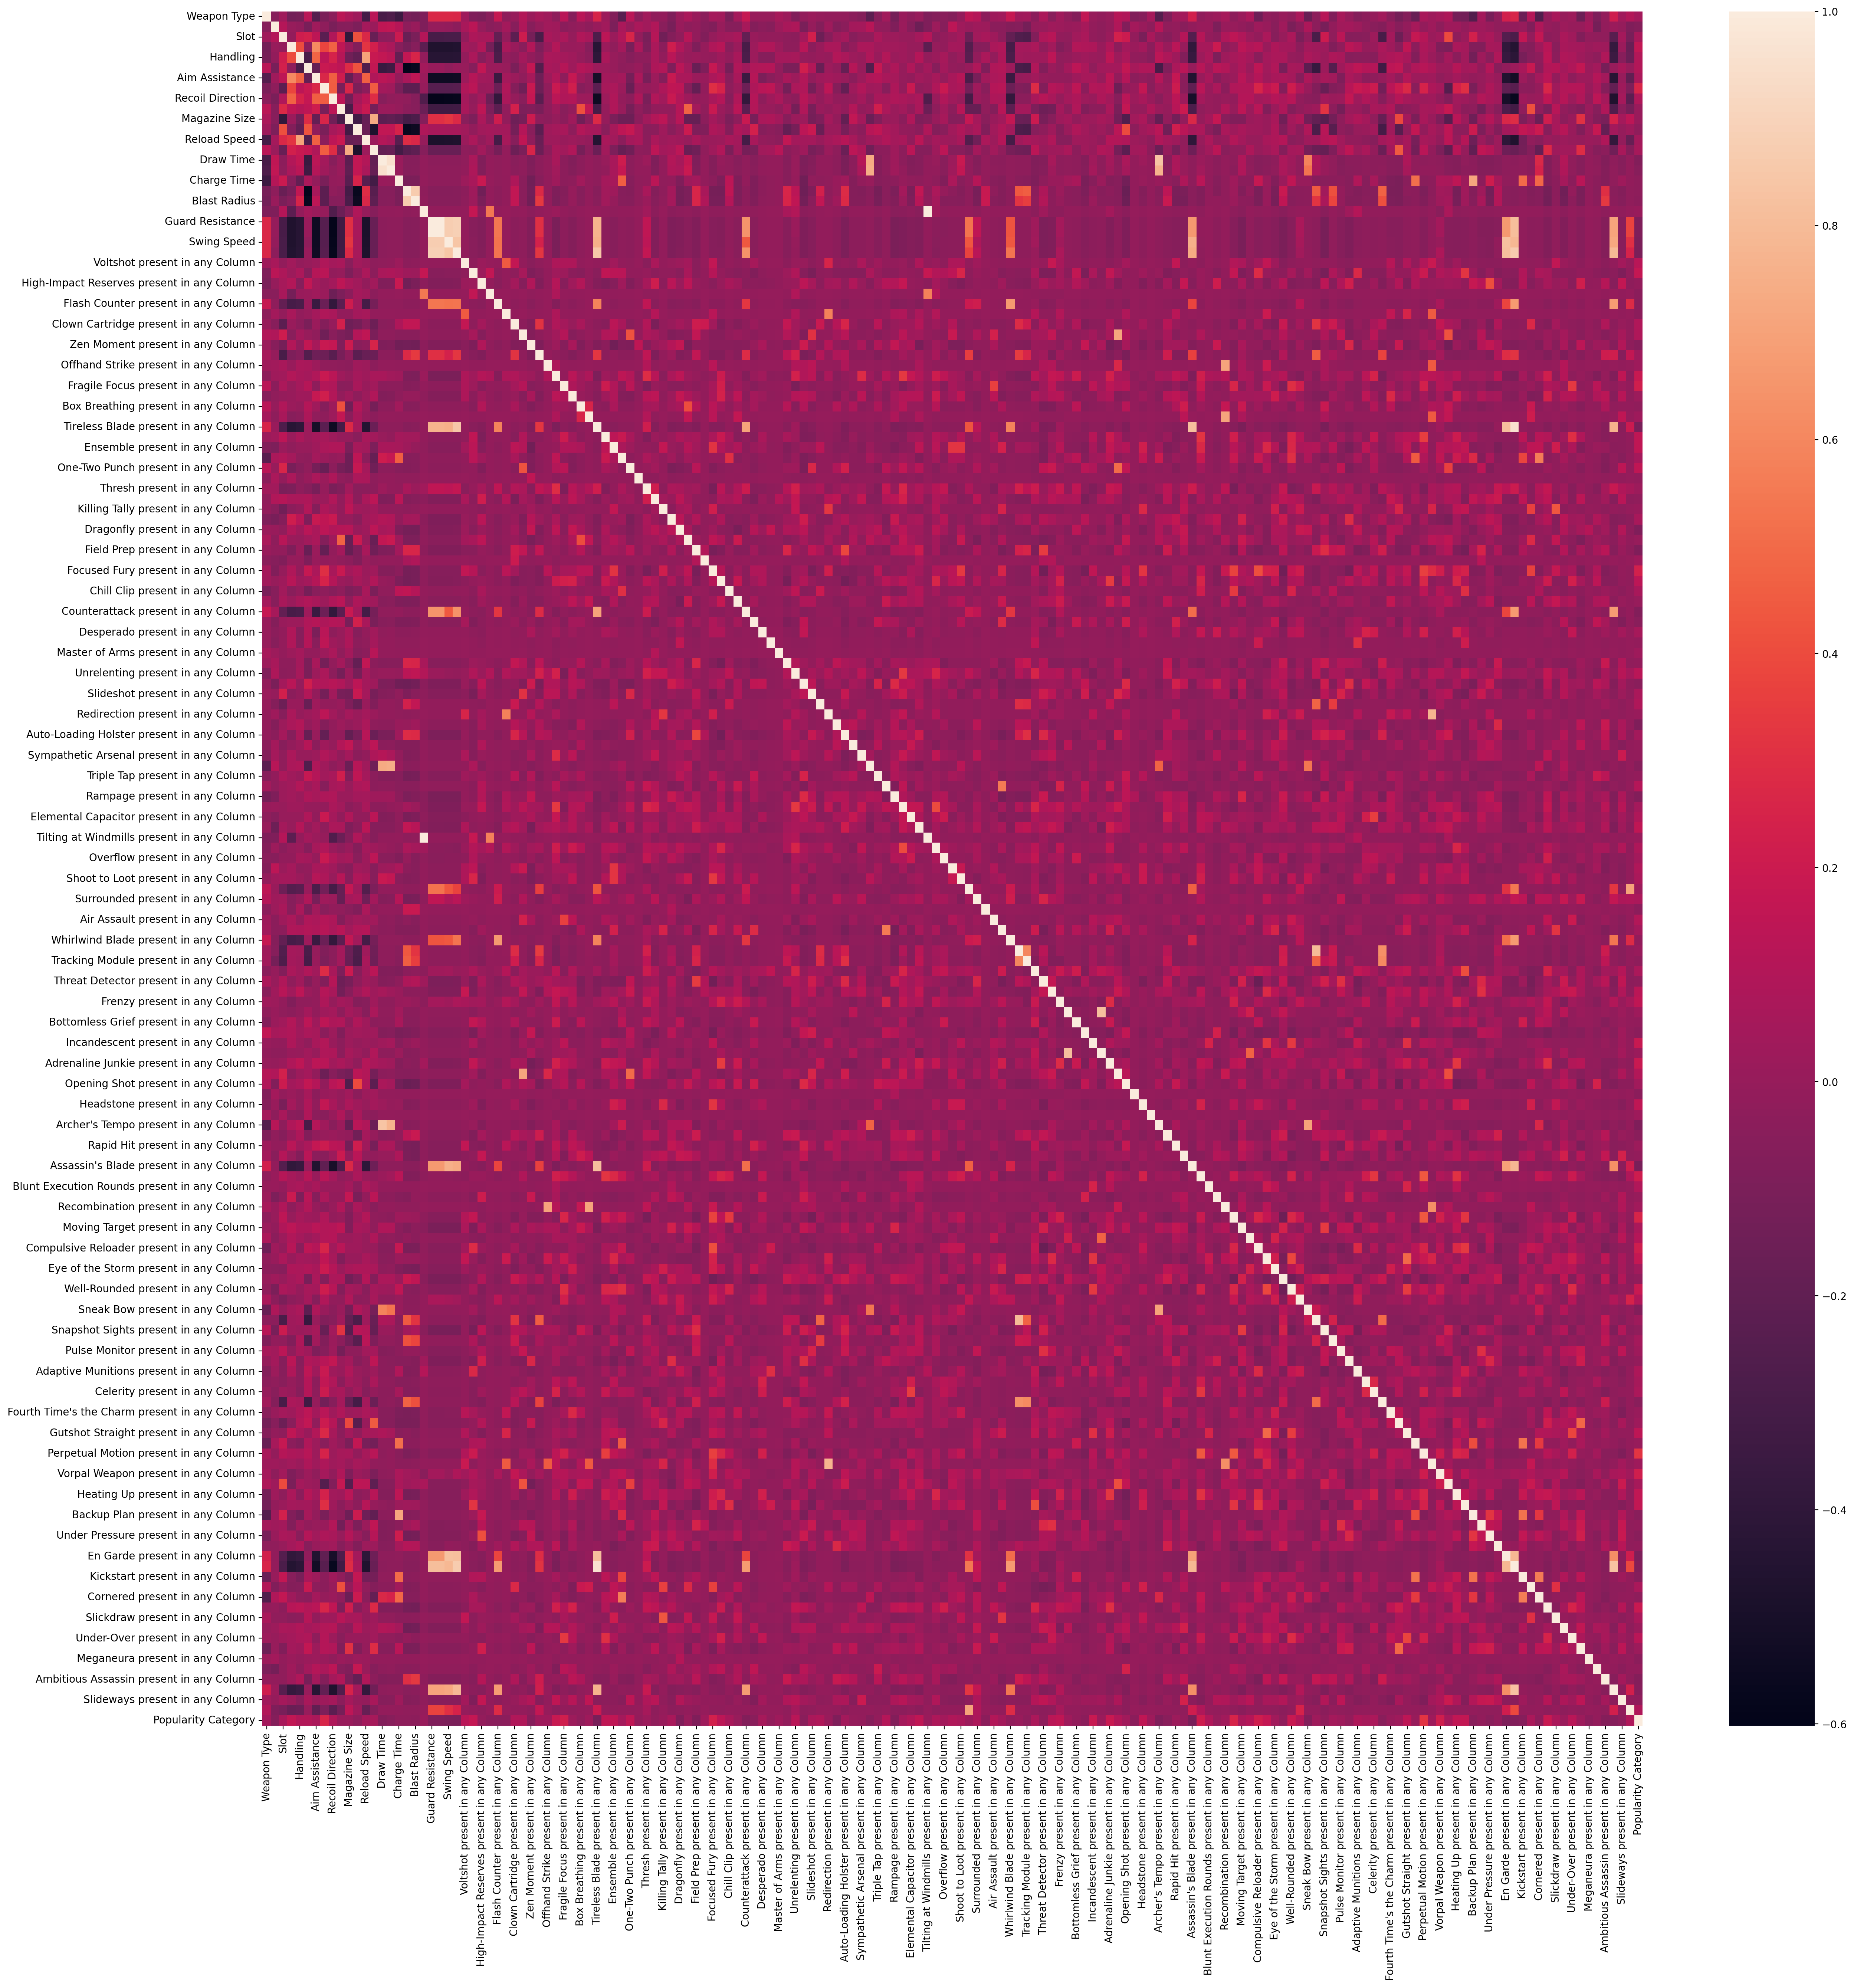

In [1]:
plt.figure(figsize=(30,30), dpi=100)
sns.heatmap(df_2.corr())
plt.show()

__NOTE: Why LabelEncode the target variable instead of using One Hot Encoding?__
In this case, label encoding is appropriate because there is an ordering property among the categories

In [8]:
def eval_and_confusion_matrix(model, X, Y, name=None, save=True ,with_heuristic_fn=None):
    Y_predict = np.rint(model.predict(X))
    m = confusion_matrix(Y, Y_predict)
    ConfusionMatrixDisplay(confusion_matrix=m, display_labels=["unpopular", 'niche', "popular"]).plot()
    release = CONFIG__DATA_FILE_NAME[:CONFIG__DATA_FILE_NAME.find('-')]
    plt.suptitle(f'{name} estimator')
    plt.title(f"'{release}' dataset, N={X.shape[0]}")
    #plt.suptitle(f'{cv.n_splits}-fold Stratified CV')
    if name is not None and save:
        plt.savefig(f'performance/{release}/{name}-{release}.png')
    else:
        print('[WARN]: Performance figure not saved for estimator ' + str(model))
    plt.show()
    
    if with_heuristic_fn is not None:
        print(f'Heuristic: {with_heuristic_fn(Y, Y_predict)}')
    return m

def weighted_failed_prediction_credit(y_true, y_predict):

    # normalize by size of Y to retain accurate metrics for different lenghts of Y
    size = y_true.shape[0]
    #print(y_true)
    #print(y_predict)
    correct_pred = y_true[ y_true == y_predict ]
    
    classified_as_popular = y_true[ y_predict == 2 ]
    #print(classified_as_popular)
    true_labels_of_misspredict_of_populars = classified_as_popular[ classified_as_popular != 2 ]
    #print(true_labels_of_misspredict_of_populars)
    p, ct = np.unique(true_labels_of_misspredict_of_populars, return_counts=True)
    fp_niche = dict(zip(p, ct))
    #print(fp_niche)
    fp_niche = fp_niche.get(1,0) / size
    
    # count of correctly predicted 'popular' instances
    p, ct = np.unique(correct_pred, return_counts=True)
    tp_popular = dict(zip(p, ct)).get(2,0) / size
    #print((tp_popular, fp_niche))
    #print()
    
    # by definition of the categories, niche comprises 40% [10,50]
    # This means the addressable area that can be classified as 'popular' is 50% (popular + niche area)
    return tp_popular + (1-(0.4+0.1))*fp_niche

sc = make_scorer(weighted_failed_prediction_credit, greater_is_better=True)
bacc = make_scorer(balanced_accuracy_score, greater_is_better=True)

In [9]:
selected = RFE(DecisionTreeClassifier(),step=1, n_features_to_select=40).fit(X,Y).support_

release = CONFIG__DATA_FILE_NAME[:CONFIG__DATA_FILE_NAME.find('-')]
with open(f"models/{release}/{release}-RFE.d2reducer", 'wb') as f:
    pickle.dump(selected, f)
print(df_2.columns[np.append(selected,[False])], len(selected), X.shape[1])

Index(['Archetype', 'Stability', 'Handling', 'Range', 'Aim Assistance',
       'Airborne Effectiveness', 'Recoil Direction', 'Zoom', 'Magazine Size',
       'Reload Speed', 'Rounds Per Minute', 'Turnabout present in any Column',
       'Chain Reaction present in any Column',
       'Killing Wind present in any Column',
       'One-Two Punch present in any Column',
       'Rangefinder present in any Column', 'Field Prep present in any Column',
       'Focused Fury present in any Column',
       'Master of Arms present in any Column',
       'Unrelenting present in any Column',
       'Elemental Capacitor present in any Column',
       'Wellspring present in any Column', 'Overflow present in any Column',
       'Whirlwind Blade present in any Column',
       'Swashbuckler present in any Column',
       'Bottomless Grief present in any Column',
       'Adrenaline Junkie present in any Column',
       'Opening Shot present in any Column',
       'Reversal of Fortune present in any Column',

## DecTree

In [10]:
grid = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid={
    'max_features' : [None, 'log2', 'sqrt'],
    'max_depth' : [10, 20, 30],
    'min_samples_leaf' : [2, 3, 4, 5, 10]
}, scoring=sc, cv=kf, verbose=1, refit='H')

r = grid.fit(X, Y)

print(r.best_params_, r.best_estimator_, r.best_score_)

dectree_sv = DecisionTreeClassifier(**r.best_params_)
dectree_sv.fit(X,Y)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3} DecisionTreeClassifier(max_depth=20, min_samples_leaf=3) 0.05744680851063829


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    0.8s finished


DecisionTreeClassifier(max_depth=20, min_samples_leaf=3)

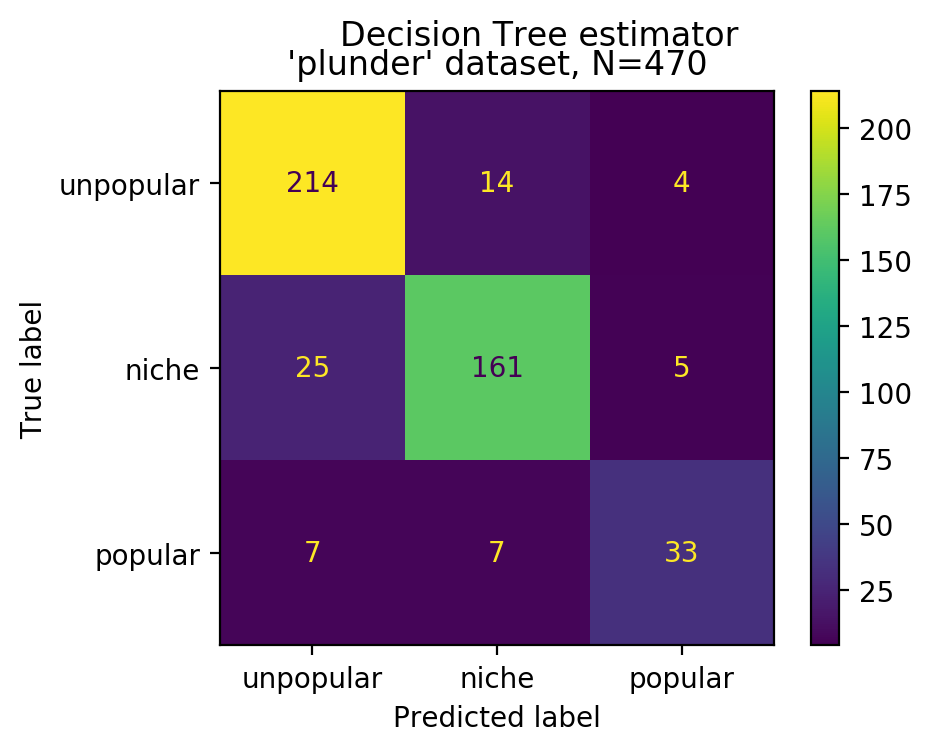

Heuristic: 0.07553191489361702


array([[214,  14,   4],
       [ 25, 161,   5],
       [  7,   7,  33]])

In [11]:
eval_and_confusion_matrix(dectree_sv, X, Y, name='Decision Tree', with_heuristic_fn=weighted_failed_prediction_credit)

# Random Forest

In [12]:
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid={
    'n_estimators' : [1_000, 10_000],
    'max_features' : [None, 'log2', 'sqrt'],
    'max_depth' : [3, 5],
    'min_samples_leaf' : [2, 5, 10]
}, scoring=sc, cv=kf, n_jobs=10, verbose=1)

r = grid.fit(X, Y)
print(r.best_params_, r.best_estimator_, r.best_score_)

randfor_sv = RandomForestClassifier(**r.best_params_)
randfor_sv.fit(X,Y)

[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=10)]: Done 360 out of 360 | elapsed: 22.3min finished


{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 1000} RandomForestClassifier(max_depth=5, max_features=None, min_samples_leaf=2,
                       n_estimators=1000) 0.007446808510638297


RandomForestClassifier(max_depth=5, max_features=None, min_samples_leaf=2,
                       n_estimators=1000)

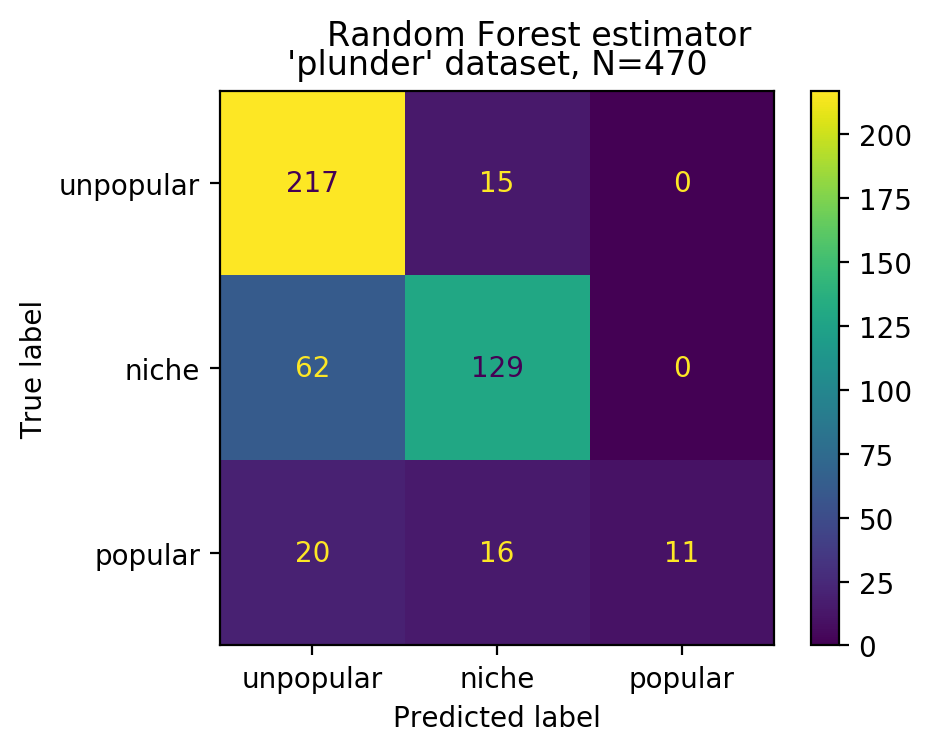

Heuristic: 0.023404255319148935


array([[217,  15,   0],
       [ 62, 129,   0],
       [ 20,  16,  11]])

In [13]:
eval_and_confusion_matrix(randfor_sv, X, Y, name="Random Forest", with_heuristic_fn=weighted_failed_prediction_credit)

## Gradient-Boosted Decision Tree

In [14]:
grid = GridSearchCV(estimator=GradientBoostingClassifier(validation_fraction=0.1, n_iter_no_change=50, tol=0.01), param_grid={
    'n_estimators' : [10_000, 100_000],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_features' : [None, 'log2', 'sqrt'],
    'max_depth' : [3, 5],
    'min_samples_leaf' : [2, 3,5],
}, scoring=sc, cv=kf, n_jobs=10, verbose=1)

r = grid.fit(X, Y)
print(r.best_params_, r.best_estimator_, r.best_score_)

bdt_sv = GradientBoostingClassifier(**r.best_params_, validation_fraction=0.1, n_iter_no_change=50, tol=0.01)
bdt_sv.fit(X,Y)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done 1080 out of 1080 | elapsed: 23.5min finished


{'learning_rate': 0.1, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 10000} GradientBoostingClassifier(max_depth=5, min_samples_leaf=2, n_estimators=10000,
                           n_iter_no_change=50, tol=0.01) 0.035106382978723406


GradientBoostingClassifier(max_depth=5, min_samples_leaf=2, n_estimators=10000,
                           n_iter_no_change=50, tol=0.01)

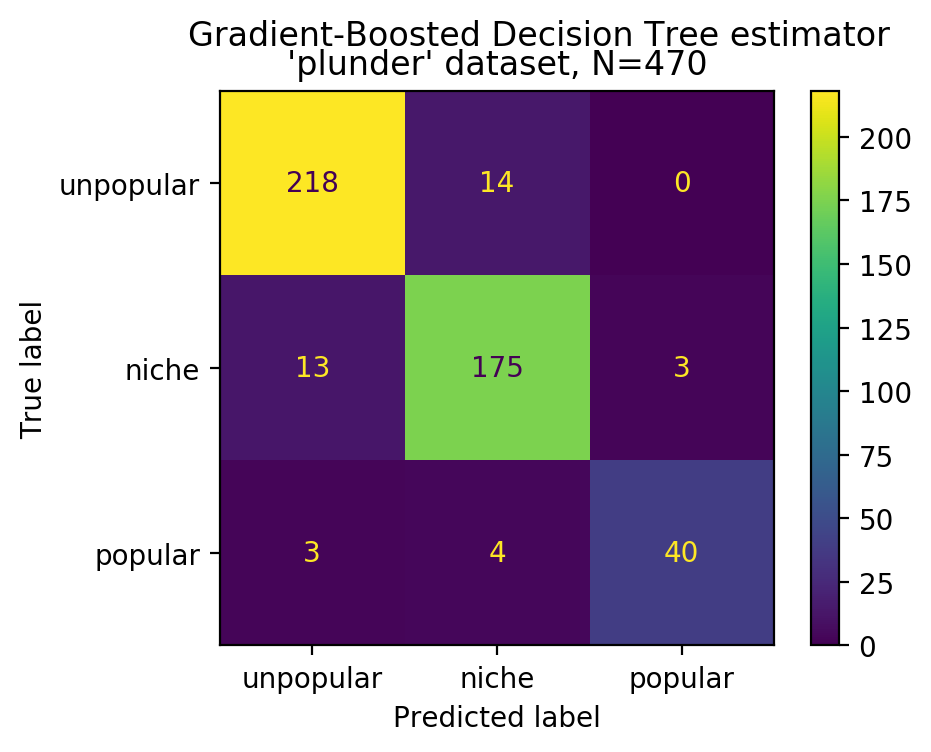

Heuristic: 0.08829787234042553


array([[218,  14,   0],
       [ 13, 175,   3],
       [  3,   4,  40]])

In [15]:
eval_and_confusion_matrix(bdt_sv, X, Y, name="Gradient-Boosted Decision Tree",with_heuristic_fn=weighted_failed_prediction_credit)

## SVM

In [16]:
grid = GridSearchCV(estimator=SVC(), param_grid={
    'C' : [50_000, 100_000, 200_000, 1_000_000],
    'gamma' : ['scale', 'auto'] 
    # For whatever reason not using gamma yields better results
    # even though it should default to gamma='auto'
}, scoring=sc, cv=kf, n_jobs=10, verbose=1)

r =grid.fit(X, Y)
print(r.best_params_, r.best_estimator_, r.best_score_)

svm_sv = SVC(**r.best_params_)
svm_sv.fit(X,Y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 50000, 'gamma': 'scale'} SVC(C=50000) 0.03829787234042553


[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed:    5.0s finished


SVC(C=50000)

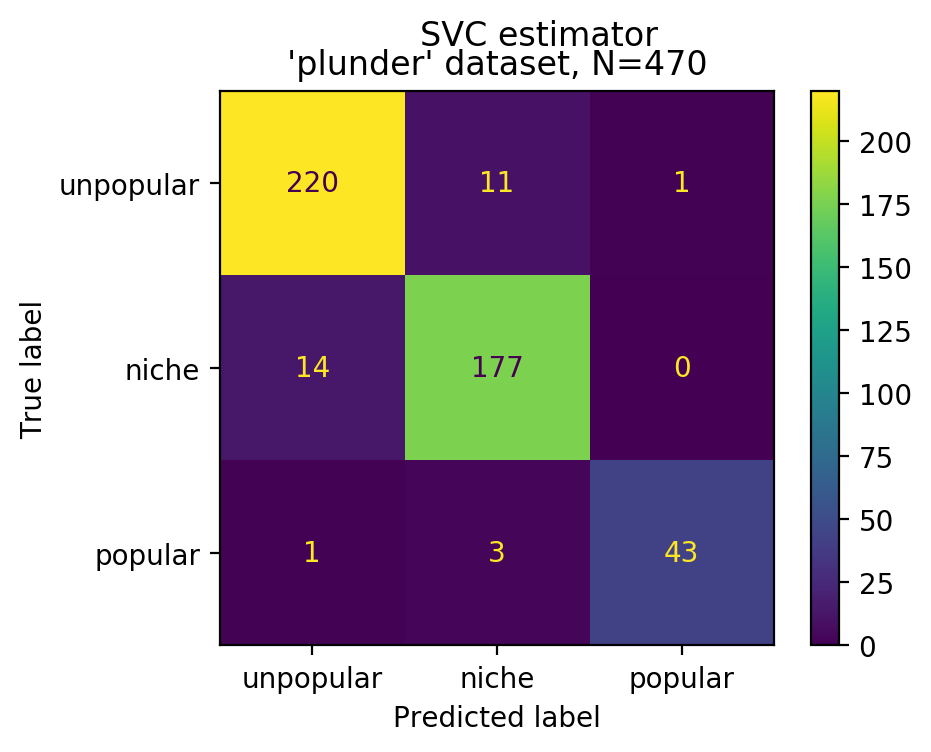

Heuristic: 0.09148936170212765


array([[220,  11,   1],
       [ 14, 177,   0],
       [  1,   3,  43]])

In [17]:
eval_and_confusion_matrix(svm_sv, X, Y, name="SVC", with_heuristic_fn=weighted_failed_prediction_credit)

# NaiveBayes

In [13]:
bnb = BernoulliNB()

results_bnb = cross_validate(bnb, X, Y, cv=kf, scoring=sc,return_estimator=True)
bnb_sv = bnb.fit(X, Y)
print(f"Metrics:WFPC={results_bnb['test_score'].mean()}")

Metrics:WFPC=0.03404255319148936


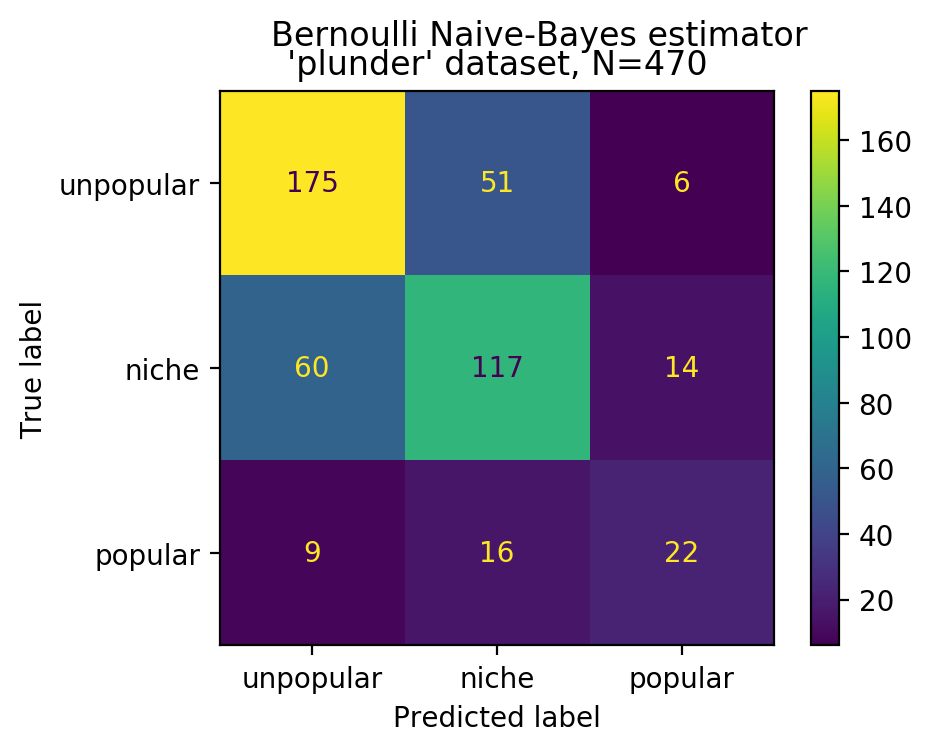

Heuristic: 0.06170212765957447


array([[175,  51,   6],
       [ 60, 117,  14],
       [  9,  16,  22]])

In [19]:
eval_and_confusion_matrix(bnb, X, Y, name="Bernoulli Naive-Bayes", with_heuristic_fn=weighted_failed_prediction_credit)

# MLPC (sklearn)

In [20]:
grid = GridSearchCV(estimator=MLPClassifier(early_stopping=True, validation_fraction=0.33), param_grid={
    'hidden_layer_sizes' : [(200, 200), (200,200,200), (1_000,1_000), (1_000,1_000,1_000)],
    'max_iter' : [50, 100, 150],
    'random_state' : [1]
}, scoring=sc, cv=kf, n_jobs=-1, verbose=1)

r = grid.fit(StandardScaler().fit_transform(X), Y)
print(r.best_params_, r.best_estimator_, r.best_score_)

mlpc_sv = MLPClassifier(**r.best_params_)
mlpc_sv.fit(X,Y)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 24.3min finished


{'hidden_layer_sizes': (200, 200), 'max_iter': 50, 'random_state': 1} MLPClassifier(early_stopping=True, hidden_layer_sizes=(200, 200), max_iter=50,
              random_state=1, validation_fraction=0.33) 0.013829787234042554


MLPClassifier(hidden_layer_sizes=(200, 200), max_iter=50, random_state=1)

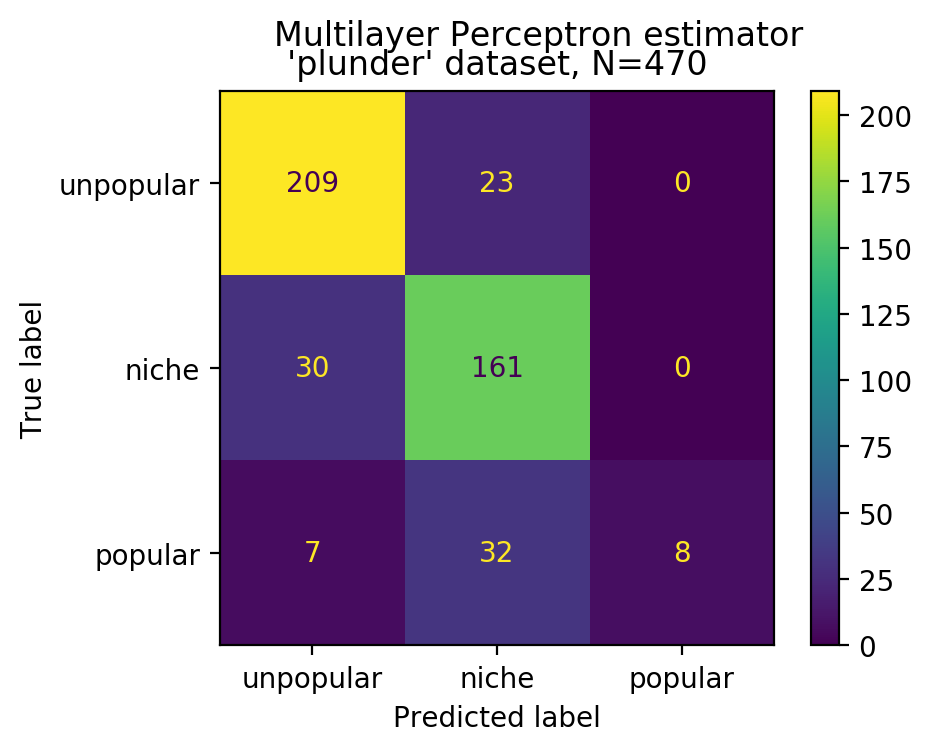

Heuristic: 0.01702127659574468


array([[209,  23,   0],
       [ 30, 161,   0],
       [  7,  32,   8]])

In [17]:
eval_and_confusion_matrix(mlpc_sv, StandardScaler().fit_transform(X), Y, name="Multilayer Perceptron", with_heuristic_fn=weighted_failed_prediction_credit)

## Model saving

In [12]:
release = CONFIG__DATA_FILE_NAME[:CONFIG__DATA_FILE_NAME.find('-')]

models = [dectree_sv, randfor_sv, bdt_sv, svm_sv, bnb_sv, mlpc_sv]
names =  ['dectree', 'randfor', 'bdt', 'svm', 'bnb','mlpc']
for model, name in zip(models, names):
    with open(f'models/{release}/{release}-{name}.d2model', 'wb') as f:
        pickle.dump(model, f)
        print(f"Saved {release}-{name}; {model}")

Saved plunder-mlpc; MLPClassifier(early_stopping=True, hidden_layer_sizes=(200, 200), max_iter=50,
              random_state=1, validation_fraction=0.33)
